In [1]:
"""
Copyright 2024 Rafael Perez Martinez

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
""";

In [2]:
import importlib
import logging
import timeit

import hola_utils as utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

importlib.reload(utils)

from hola.algorithm import HOLA
from hola.tune import tune
from matplotlib import rcParams

rcParams.update({"figure.autolayout": True})

from pathlib import Path
from typing import Any, Dict, List, Tuple


In [3]:
# Load the CSV file
df = pd.read_csv(r'./data/df_simulated_large_signal_modulated.csv')

# Filter the DataFrame for VGS values less than or equal to -1.2 V
filtered_df = df[df['vgs'] <= -1.2].copy()


# We adjust the objectives we wish to maximize by multiplying them by −1
filtered_df.loc[:, 'Pdel_dBm'] = -filtered_df['Pdel_dBm']
filtered_df.loc[:, 'PAE'] = -filtered_df['PAE']

# Group by the specified columns and calculate the maximum for each group
grouped_max_df = filtered_df.groupby(['vds', 'wg', 'nfing', 'gdg', 'gsg']).max().reset_index()

# Constraint for ACPR is less than or equal to -30 dBc
grouped_max_df['ACPR'] = pd.to_numeric(grouped_max_df['ACPR'], errors='coerce')
filtered_grouped_df = grouped_max_df[grouped_max_df['ACPR'] <= -30].copy()

# Calculate the 'area' directly using pandas operations
filtered_grouped_df['area'] = filtered_grouped_df['nfing'] * filtered_grouped_df['wg']

# Extract relevant columns as pandas Series
arr_vds = filtered_grouped_df['vds']
arr_wg = filtered_grouped_df['wg']
arr_nfing = filtered_grouped_df['nfing']
arr_gdg = filtered_grouped_df['gdg']
arr_gsg = filtered_grouped_df['gsg']

# Extract and process objective columns
arr_Pout_mod = -filtered_grouped_df['Pdel_dBm']  # Want to maximize
arr_PAE_mod = -filtered_grouped_df['PAE']    # Want to maximize
arr_ACPR = filtered_grouped_df['ACPR']      # Want to minimize    
arr_Tj_mod = filtered_grouped_df['Tj']   # Want to minimize

# Calculate counts of unique values for each variable
vds_count = arr_vds.nunique()
wg_count = arr_wg.nunique()
nfing_count = arr_nfing.nunique()
gdg_count = arr_gdg.nunique()
gsg_count = arr_gsg.nunique()

# Print counts
print(f'vds count is {vds_count}, wg count is {wg_count}, nfing count is {nfing_count}, '
      f'gdg count is {gdg_count}, gsg count is {gsg_count}')

# Calculate total count
total_count = vds_count * wg_count * nfing_count * gdg_count * gsg_count
print(f'Total count is {total_count}')

# Optionally, save the processed DataFrame to a CSV file
filtered_grouped_df.to_csv(r'./file_check/file_grouped_post_process.csv', index=False)

vds count is 4, wg count is 7, nfing count is 4, gdg count is 2, gsg count is 3
Total count is 672


In [4]:
data = np.column_stack((-arr_Pout_mod, -arr_PAE_mod, arr_Tj_mod))
pareto_efficient = utils.is_pareto_efficient(data)

pp = data[pareto_efficient] # Non-dominated points

dp = data[~pareto_efficient] # Dominated points

# To get back the original values, multiply the first three columns by -1
pp[:, :2] *= -1
dp[:, :2] *= -1
print(f'Pareto shape is {pp.shape}')
print(f'Dominated shape is {dp.shape}')

Pareto shape is (39, 3)
Dominated shape is (491, 3)


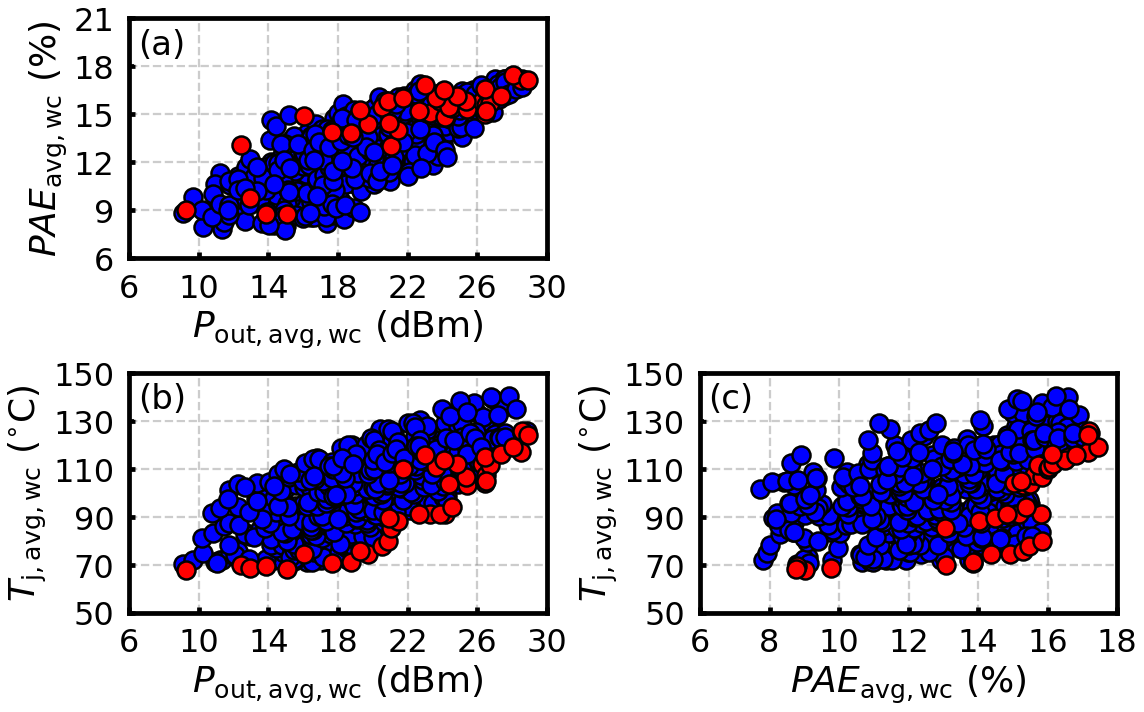

In [5]:
# Define labels
x_labels = [
    r'$P_{\mathrm{out,avg,wc}}$ (dBm)',
    r'',  
    r'$P_{\mathrm{out,avg,wc}}$ (dBm)',
    r'$PAE_{\mathrm{avg,wc}}$ (%)'
]

y_labels = [
    r'$PAE_{\mathrm{avg,wc}}$ (%)',
    r'',  
    r'$T_{\mathrm{j,avg,wc}}$ ($^{\circ}$C)',
    r'$T_{\mathrm{j,avg,wc}}$ ($^{\circ}$C)'
]


# Define ticks
x_ticks = [
    np.arange(6, 34, 4),
    None,  
    np.arange(6, 34, 4),
    np.arange(6, 21, 2)
]

y_ticks = [
    np.arange(6, 24, 3),
    None,  
    np.arange(50, 151, 20),
    np.arange(50, 151, 20)
]

# Define axis ranges
x_ranges = [
    (6, 30),
    (0, 0),  
    (6, 30),
    (6, 18)
]

y_ranges = [
    (6, 21),
    (0, 0),  
    (50, 150),
    (50, 150)
]

utils.subplot_data(
    dp=dp,
    pp=pp,
    x_labels=x_labels,
    y_labels=y_labels,
    x_ticks=x_ticks,
    y_ticks=y_ticks,
    x_ranges=x_ranges,
    y_ranges=y_ranges,
    figsize=(16, 10),
    save_path="Fig_2.pdf"  # Set to None if you don't want to save
)

In [6]:
# Define labels
x_label = r'$P_{\mathrm{out,avg,wc}}$ (dBm)'
y_label = r'$PAE_{\mathrm{avg,wc}}$ (%)'
z_label = r'$T_{\mathrm{j,avg,wc}}$ ($^{\circ}$C)'

# Define ticks
x_ticks = np.arange(8, 33, 4)
y_ticks = np.arange(6, 19, 3)
z_ticks = np.arange(60, 161, 20)

# Define axis ranges
x_range = (8, 32)
y_range = (6, 18)
z_range = (60, 160)

# Call the function
utils.plot_pareto_frontier_3d(
    data=dp,
    pareto_front=pp,
    x_label=x_label,
    y_label=y_label,
    z_label=z_label,
    x_ticks=x_ticks,
    y_ticks=y_ticks,
    z_ticks=z_ticks,
    x_range=x_range,
    y_range=y_range,
    z_range=z_range,
    figsize=(7, 7),
    dpi=1000,
    save_path="Fig_3.pdf"  # Set to None if you don't want to save
)

In [7]:
data_attr = np.column_stack((arr_vds , arr_nfing, arr_wg, arr_gdg, arr_gsg, arr_Pout_mod, arr_PAE_mod, arr_Tj_mod))
data_attr_pareto = data_attr[pareto_efficient]
headers = ["vds", "nfing", "wf", "gdg", "gsg", "Pout", "PAE", "Tj"]

df = pd.DataFrame(data_attr_pareto, columns=headers)

df.to_csv('./Pareto_designs/modulated_signal_pareto.csv', index=False)

In [8]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

val_vds = np.unique(arr_vds).tolist()
val_wg = np.unique(arr_wg).tolist()
val_nfing = np.unique(arr_nfing).tolist()
val_gdg = np.unique(arr_gdg).tolist()
val_gsg = np.unique(arr_gsg).tolist()

# Define parameter configurations
params_config = {
    "vds": {
        "min": 16,
        "max": 28,
        "param_type": "int",
        "values": val_vds  
    },
    "nfing": {
        "min": 2,
        "max": 8,
        "param_type": "int",
        "values": val_nfing  
    },
    "wg": {
        "min": 25,
        "max": 100,
        "param_type": "int",
        "values": val_wg  
    },
    "gdg": {
        "min": 22,
        "max": 52,
        "param_type": "int",
        "values": val_gdg  
    },
    "gsg": {
        "min": 33,
        "max": 78,
        "param_type": "int",
        "values": val_gsg  
    }
}

data_arrays = {
    "vds": arr_vds,
    "wg": arr_wg,
    "nfing": arr_nfing,
    "gdg": arr_gdg,
    "gsg": arr_gsg,
    "Pout": arr_Pout_mod,
    "PAE": arr_PAE_mod,
    "Tj": arr_Tj_mod
}

INFO: Starting run 1/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet i

INFO: Device design does not meet imposed constraints: vds=28.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Time taken for tuning: 0.29 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 6.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 28.077059999999996, 'PAE': 17.43691, 'Tj': 118.95838}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 1.0697606666666668
INFO: The score for trial 15 is: 0.0
INFO: The score for trial 30 is: 0.0
INFO: The score for trial 45 is: 0.0
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 5/100
INFO: Starting run 6/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed

INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Time taken for tuning: 0.27 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 6.0, 'wg': 100.0, 'gdg': 22.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO:

INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.25 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 6.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 28.077059999999996, 'PAE': 17.43691, 'Tj': 118.95838}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.6474178333333332
INFO: The score for trial 15 is: 0.05469133333333309
INFO: The score for trial 30 is: 0.05469133333333309
INFO: The score for trial 45 is: 0.044766000000000306
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 14/100
INFO: Starting r

INFO: {'Pout': 27.573320000000002, 'PAE': 17.19979, 'Tj': 119.67251999999999}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.37123799999999985
INFO: The score for trial 30 is: 0.2994326666666668
INFO: The score for trial 45 is: 0.021333999999999853
INFO: The score for trial 60 is: 0.021333999999999853
INFO: The score for trial 75 is: 0.021333999999999853
INFO: Completed run 18/100
INFO: Starting run 19/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design 

INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=28.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=28.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Time taken for tuning: 0.25 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 6.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 48.0}
INFO: Best Objectives:
INF

INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.26864316666666666
INFO: The score for trial 15 is: 0.26864316666666666
INFO: The score for trial 30 is: 0.26864316666666666
INFO: The score for trial 45 is: 0.10513600000000001
INFO: The score for trial 60 is: 0.021333999999999853
INFO: The score for trial 75 is: 0.021333999999999853
INFO: Completed run 27/100
INFO: Starting run 28/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8

INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Time taken for tuning: 0.28 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 6.0, 'wg': 100.0, 'gdg': 22.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 27.613329999999998, 'PAE': 17.209770000000002, 'Tj': 124.94233999999999}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.3257948333333335
INFO: The score for trial 15 is: 0.2708606666666665
INFO: The score for trial 30 is: 0.20463466666666674
INFO: The score for trial 45 is: 0.17824533333333348
INFO: The score for trial 60 is: 0.019333500000000114
INFO: The score for trial 75 is: 0.019333500000000114
INFO: Completed run 32/100
INFO: Starting run 33/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed c

INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Time taken for tuning: 0.25 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 6.0, 'wg': 87.5, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 27.573320000000002, 'PAE': 17.19979, 'Tj': 119.67251999999999}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 1.06723
INFO: The score for trial 15 is: 0.38038136666666655
INFO: The score for

INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 41/100
INFO: Starting run 42/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet impo

INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.25 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 8.0, 'wg': 87.5, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 28.522470000000002, 'PAE': 17.16033, 'Tj': 116.91703999999999}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.2555208333333334
INFO: The score for trial 15 is: 0.1907593333333335
INFO: The score for trial 30 is: 0.0
INFO: The score for trial 45 is: 0.0
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 46/100
INFO: Starting run 47/100
INFO: Device de

INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Time taken for tuning: 0.28 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 8.0, 'wg': 87.5, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 28.522470000000002, 'PAE': 17.16033, 'Tj': 116.91703999999999}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 1.1203893333333335
INFO: The score for trial 15 is: 0.39286166666666666
INFO: The score for trial 30 is: 0.15331216666666658
INFO: The score for trial 45 is: 0.15331216666666658
INFO: The score for trial 60 is: 0.021333999999999853
INFO: The score for trial 75 is: 0.0
INFO: Completed run 50/100
INFO: Starting run 51/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.

INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.

INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=78
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=28.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Time taken for tuning: 0.30 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 6.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 28.077059999999996, 'PAE': 17.43691, 'Tj': 118.95838}
INFO: Optimal score: 0.0
INFO: The score fo

INFO: The score for trial 1 is: 1.271226
INFO: The score for trial 15 is: 0.019333500000000114
INFO: The score for trial 30 is: 0.019333500000000114
INFO: The score for trial 45 is: 0.019333500000000114
INFO: The score for trial 60 is: 0.019333500000000114
INFO: The score for trial 75 is: 0.01892499999999997
INFO: Completed run 63/100
INFO: Starting run 64/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Devic

INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Time taken for tuning: 0.25 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 8.0, 'wg': 75.0, 'gdg': 22.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 27.159029999999998, 'PAE': 16.967389999999998, 'Tj': 121.64799}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.12589250000000007
INFO: The score for t

INFO: The score for trial 15 is: 0.01892499999999997
INFO: The score for trial 30 is: 0.01892499999999997
INFO: The score for trial 45 is: 0.01892499999999997
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 72/100
INFO: Starting run 73/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=28.0, wg=100.0, nfing=8.0, gd

INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.

INFO: {'Pout': 28.95595, 'PAE': 17.172520000000002, 'Tj': 124.12722}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.5079115333333337
INFO: The score for trial 15 is: 0.19215833333333332
INFO: The score for trial 30 is: 0.0
INFO: The score for trial 45 is: 0.0
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 81/100
INFO: Starting run 82/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing

INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.28 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 4.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 26.224529999999998, 'PAE': 16.80365, 'Tj': 119.31993}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.2592380000000001
INFO: The score for trial 30 is: 0.2592380000000001
INFO: The score for trial 45 is: 0.2592380000000001
INFO: The score for trial 60 is: 0.2592380000000001
INFO: The score for trial 75 is: 0.10513600000000001
INFO: Completed run 86/100
INFO:

INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Time taken for tuning: 0.29 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 6.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 28.077059999999996, 'PAE': 17.43691, 'Tj': 118.95838}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.0
INFO: The score for trial 30 is: 0.0
INFO: The score for trial 45 is: 0.0
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 90/100
INFO: Starting run 91/100
INFO: Device design does not meet imposed constraints:

INFO: The score for trial 30 is: 0.20305516666666656
INFO: The score for trial 45 is: 0.20305516666666656
INFO: The score for trial 60 is: 0.20305516666666656
INFO: The score for trial 75 is: 0.16915216666666655
INFO: Completed run 94/100
INFO: Starting run 95/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=33.0
INF

INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Time taken for tuning: 0.23 seconds
INFO: Best Parameters:
INFO: {'vds': 28.0, 'nfing': 6.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 48.0}
INFO: Best Objectives:
INFO: 

Saved all_score_tallies.csv to Pareto_designs/modulated_signal_objectives_1_results/all_score_tallies.csv
Saved mean_std_scores.csv to Pareto_designs/modulated_signal_objectives_1_results/mean_std_scores.csv
Saved final_scores.csv to Pareto_designs/modulated_signal_objectives_1_results/final_scores.csv
Saved final_statistics.csv to Pareto_designs/modulated_signal_objectives_1_results/final_statistics.csv


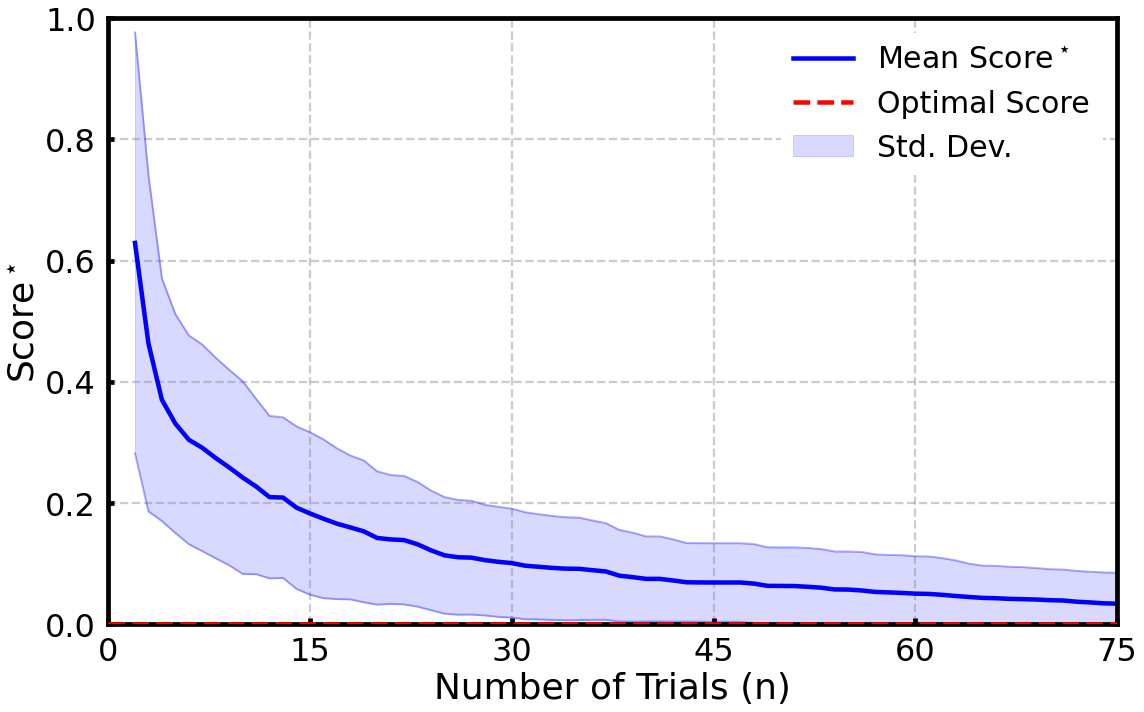

Final Score Across Runs:
Mean: 0.033
Standard Deviation: 0.0511


In [9]:
n_runs = 100 # Number of independent runs
trials = 75  # Number of trials per independent run

objectives_1 = {
    "Pout": {"target": 28, "limit": 8, "priority": 1},
    "PAE": {"target": 17, "limit": 5, "priority": 1},
    "Tj": {"target": 125, "limit": 150, "priority": 1}
}

# Run multiple HOLA optimization trials
benchmark_results_1 = utils.run_multiple_hola_trials(
    n_runs=n_runs,
    trials=trials,
    objectives=objectives_1,
    tune_function=tune,
    data_arrays=data_arrays,
    params_config=params_config
)

# Save results
utils.save_results_to_csv(benchmark_results_1, output_dir=r'./Pareto_designs/modulated_signal_objectives_1_results')

# Plot the benchmark results
utils.plot_benchmark_results(
    mean_scores=benchmark_results_1["mean_scores"],
    std_scores=benchmark_results_1["std_scores"],
    trials=trials,
    data_arrays=data_arrays,
    objectives=objectives_1
)

# Display aggregate statistics
print(f"Final Score Across Runs:")
print(f"Mean: {benchmark_results_1['final_mean']:.3f}")
print(f"Standard Deviation: {benchmark_results_1['final_std']:.4f}")

In [10]:
check_points = [1, 15, 30, 45, 60, 75] # Trial checkpoints
tolerance = 0.05 # Tolerance from optimal score

print("=== Evaluating Mean Score* ===")
utils.evaluate_mean_scores(
    benchmark_results=benchmark_results_1,
    check_points=check_points,
)

print("\n=== Evaluating Runs Reaching Optimal Score ===")
optimal_score_1, _ = utils.evaluate_runs(
    objectives=objectives_1,
    data_arrays=data_arrays,
    benchmark_results=benchmark_results_1,
    check_points=check_points,
    tolerance=None,
    compute_threshold_func=utils.compute_threshold,
    score_calculation_func=utils.calculate_score
)

print("\n=== Evaluating Runs Within Tolerance of Optimal Score ===")
optimal_score_1, threshold = utils.evaluate_runs(
    objectives=objectives_1,
    data_arrays=data_arrays,
    benchmark_results=benchmark_results_1,
    check_points=check_points,
    tolerance=tolerance,
    compute_threshold_func=utils.compute_threshold,
    score_calculation_func=utils.calculate_score
)

INFO: Optimal score: 0.0
INFO: Optimal score: 0.0


=== Evaluating Mean Score* ===
After 1 trials, the Mean Score: inf
After 15 trials, the Mean Score: 0.182
After 30 trials, the Mean Score: 0.100
After 45 trials, the Mean Score: 0.068
After 60 trials, the Mean Score: 0.050
After 75 trials, the Mean Score: 0.033

=== Evaluating Runs Reaching Optimal Score ===
After 1 trials, 1 out of 100 runs reached the optimal score.
After 15 trials, 6 out of 100 runs reached the optimal score.
After 30 trials, 13 out of 100 runs reached the optimal score.
After 45 trials, 17 out of 100 runs reached the optimal score.
After 60 trials, 30 out of 100 runs reached the optimal score.
After 75 trials, 44 out of 100 runs reached the optimal score.

=== Evaluating Runs Within Tolerance of Optimal Score ===
After 1 trials, 1 out of 100 runs are within 5.0% of the optimal score (optimal_score=0.000).
After 15 trials, 27 out of 100 runs are within 5.0% of the optimal score (optimal_score=0.000).
After 30 trials, 42 out of 100 runs are within 5.0% of the optimal

INFO: Starting run 1/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet impo

INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Time taken for tuning: 0.26 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 4.0, 'wg': 87.5, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {

INFO: Time taken for tuning: 0.28 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 4.0, 'wg': 87.5, 'gdg': 52.0, 'gsg': 33.0}
INFO: Best Objectives:
INFO: {'Pout': 23.15679, 'PAE': 15.110879999999998, 'Tj': 96.30183000000001}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.4791676000000001
INFO: The score for trial 15 is: 0.02603660000000019
INFO: The score for trial 30 is: 0.02603660000000019
INFO: The score for trial 45 is: 0.02603660000000019
INFO: The score for trial 60 is: 0.02603660000000019
INFO: The score for trial 75 is: 0.02603660000000019
INFO: Completed run 9/100
INFO: Starting run 10/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: v

INFO: The score for trial 15 is: 0.31444000000000016
INFO: The score for trial 30 is: 0.1539636363636364
INFO: The score for trial 45 is: 0.1539636363636364
INFO: The score for trial 60 is: 0.06355899999999992
INFO: The score for trial 75 is: 0.0
INFO: Completed run 13/100
INFO: Starting run 14/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0,

INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.

INFO: Time taken for tuning: 0.33 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 4.0, 'wg': 87.5, 'gdg': 52.0, 'gsg': 33.0}
INFO: Best Objectives:
INFO: {'Pout': 23.15679, 'PAE': 15.110879999999998, 'Tj': 96.30183000000001}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.5552916000000002
INFO: The score for trial 15 is: 0.06355899999999992
INFO: The score for trial 30 is: 0.06355899999999992
INFO: The score for trial 45 is: 0.06355899999999992
INFO: The score for trial 60 is: 0.06355899999999992
INFO: The score for trial 75 is: 0.02603660000000019
INFO: Completed run 22/100
INFO: Starting run 23/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: v

INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.32 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 4.0, 'wg': 87.5, 'gdg': 52.0, 'gsg': 48.0}
INFO: Best Objectives:
INFO: {'Pout': 23.43599, 'PAE': 15.39144, 'Tj': 95.57772}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.29690629090909104
INFO: The score for trial 30 is: 0.1539636

INFO: The score for trial 45 is: 0.030930909090908898
INFO: The score for trial 60 is: 0.030930909090908898
INFO: The score for trial 75 is: 0.0
INFO: Completed run 31/100
INFO: Starting run 32/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.

INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=33.0
INFO: Time taken for tuning: 0.33 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 4.0, 'wg': 100.0, 'gdg': 22.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 24.25374, 'PAE': 15.09748, 'Tj': 98.51404000000001}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.4390543636363635
INFO: The score for trial 15 is: 0.17255258181818198
INFO: The score for trial 30 is: 0.07028080000000017
INFO: The score for trial 45 is: 0.07028080000000017
INFO: The score for trial 60 is: 0.07028080000000017
INFO: The score for trial 75 is: 0.07028080000000017
INFO: Complet

INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Time taken for tuning: 0.35 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 6.0, 'wg': 62.5, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 23.26725, 'PAE': 15.081570000000001, 'Tj': 91.05884}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.8993062000000003
INFO: The score for trial 15 is: 0.15351039999999982
INFO: The score for trial 30 is: 0.15351039999999982
INFO: The score for trial 45 is: 0.07028080000000017
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 40/100
INFO: Starting run 41/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, 

INFO: Best Objectives:
INFO: {'Pout': 22.659760000000002, 'PAE': 15.181120000000002, 'Tj': 91.03425}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 1.5903993272727275
INFO: The score for trial 15 is: 0.21318700000000013
INFO: The score for trial 30 is: 0.1735329999999999
INFO: The score for trial 45 is: 0.030930909090908898
INFO: The score for trial 60 is: 0.030930909090908898
INFO: The score for trial 75 is: 0.030930909090908898
INFO: Completed run 44/100
INFO: Starting run 45/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, g

INFO: The score for trial 45 is: 0.17266780000000012
INFO: The score for trial 60 is: 0.07770636363636385
INFO: The score for trial 75 is: 0.07770636363636385
INFO: Completed run 48/100
INFO: Starting run 49/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds

INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=78.0
INFO: Time taken for tuning: 0.31 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 4.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 24.5629, 'PAE': 15.388079999999999, 'Tj': 94.09775}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.030930909090908898
INFO: The score for trial 30 is: 0.030930909090908898
INFO: The score for trial 45 is: 0.030930909090908898
INFO: The score for trial 60 is: 0.030930909090908898
INFO: The score for trial 75 is: 0.0
INFO: Completed run 53/100
INFO: Starting ru

INFO: Time taken for tuning: 0.31 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 6.0, 'wg': 62.5, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 23.26725, 'PAE': 15.081570000000001, 'Tj': 91.05884}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.21913545454545447
INFO: The score for trial 15 is: 0.16512680000000018
INFO: The score for trial 30 is: 0.011554399999999987
INFO: The score for trial 45 is: 0.011554399999999987
INFO: The score for trial 60 is: 0.011554399999999987
INFO: The score for trial 75 is: 0.0
INFO: Completed run 57/100
INFO: Starting run 58/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfin

INFO: {'vds': 20.0, 'nfing': 4.0, 'wg': 87.5, 'gdg': 52.0, 'gsg': 48.0}
INFO: Best Objectives:
INFO: {'Pout': 23.43599, 'PAE': 15.39144, 'Tj': 95.57772}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.6330321272727272
INFO: The score for trial 15 is: 0.13013090909090896
INFO: The score for trial 30 is: 0.13013090909090896
INFO: The score for trial 45 is: 0.13013090909090896
INFO: The score for trial 60 is: 0.02603660000000019
INFO: The score for trial 75 is: 0.011554399999999987
INFO: Completed run 61/100
INFO: Starting run 62/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=28.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet i

INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0

INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16

INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=28.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=2

INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Time taken for tuning: 0.29 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 6.0, 'wg': 62.5, 'gdg': 22.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 23.07396, 'PAE': 15.258339999999999, 'Tj': 94.6454}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.22893090909090896
INFO: The score for trial 30 is: 0.04088239999999985
INFO: The score for trial 45 is: 0.0
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 78/100
INFO: Starting run 79/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does 

INFO: The score for trial 45 is: 0.0
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 82/100
INFO: Starting run 83/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
I

INFO: Completed run 86/100
INFO: Starting run 87/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: De

INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Time taken for tuning: 0.29 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 4.0, 'wg': 87.5, 'gdg': 52.0, 'gsg': 33.0}
INFO: Best Objectives:
INFO: {'P

INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Time taken for tuning: 0.28 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 6.0, 'wg': 75.0, 'gdg': 52, 'gsg': 78}
INFO: Best Objectives:
INFO: {'Pout': 24.17474, 'PAE': 14.838579999999999, 'Tj': 90.97001}
INFO: Optimal score: 0.0
INFO: The score for

INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.

Saved all_score_tallies.csv to Pareto_designs/modulated_signal_objectives_2_results/all_score_tallies.csv
Saved mean_std_scores.csv to Pareto_designs/modulated_signal_objectives_2_results/mean_std_scores.csv
Saved final_scores.csv to Pareto_designs/modulated_signal_objectives_2_results/final_scores.csv
Saved final_statistics.csv to Pareto_designs/modulated_signal_objectives_2_results/final_statistics.csv


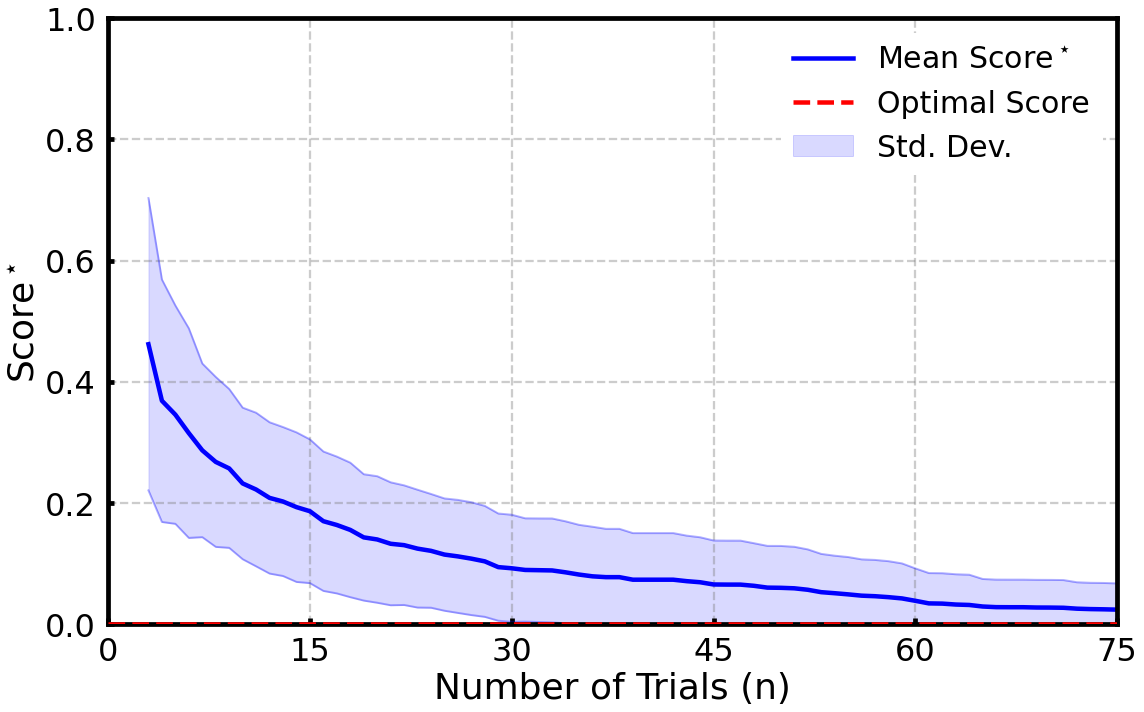

Final Score Across Runs:
Mean: 0.023
Standard Deviation: 0.0434


In [11]:
n_runs = 100 # Number of independent runs
trials = 75  # Number of trials per independent run

objectives_2 = {
    "Pout": {"target": 23, "limit": 12, "priority": 1},
    "PAE": {"target": 15, "limit": 5, "priority": 1},
    "Tj": {"target": 95, "limit": 145, "priority": 1}
}

# Run multiple HOLA optimization trials
benchmark_results_2 = utils.run_multiple_hola_trials(
    n_runs=n_runs,
    trials=trials,
    objectives=objectives_2,
    tune_function=tune,
    data_arrays=data_arrays,
    params_config=params_config
)

# Save results
utils.save_results_to_csv(benchmark_results_2, output_dir=r'./Pareto_designs/modulated_signal_objectives_2_results')

# Plot the benchmark results
utils.plot_benchmark_results(
    mean_scores=benchmark_results_2["mean_scores"],
    std_scores=benchmark_results_2["std_scores"],
    trials=trials,
    data_arrays=data_arrays,
    objectives=objectives_2
)

# Display aggregate statistics
print(f"Final Score Across Runs:")
print(f"Mean: {benchmark_results_2['final_mean']:.3f}")
print(f"Standard Deviation: {benchmark_results_2['final_std']:.4f}")


In [12]:
check_points = [1, 15, 30, 45, 60, 75] # Trial checkpoints
tolerance = 0.05 # Tolerance from optimal score

print("=== Evaluating Mean Score* ===")
utils.evaluate_mean_scores(
    benchmark_results=benchmark_results_2,
    check_points=check_points,
)

print("\n=== Evaluating Runs Reaching Optimal Score ===")
optimal_score_2, _ = utils.evaluate_runs(
    objectives=objectives_2,
    data_arrays=data_arrays,
    benchmark_results=benchmark_results_2,
    check_points=check_points,
    tolerance=None,
    compute_threshold_func=utils.compute_threshold,
    score_calculation_func=utils.calculate_score
)

print("\n=== Evaluating Runs Within Tolerance of Optimal Score ===")
optimal_score_2, threshold = utils.evaluate_runs(
    objectives=objectives_2,
    data_arrays=data_arrays,
    benchmark_results=benchmark_results_2,
    check_points=check_points,
    tolerance=tolerance,
    compute_threshold_func=utils.compute_threshold,
    score_calculation_func=utils.calculate_score
)


INFO: Optimal score: 0.0
INFO: Optimal score: 0.0


=== Evaluating Mean Score* ===
After 1 trials, the Mean Score: inf
After 15 trials, the Mean Score: 0.186
After 30 trials, the Mean Score: 0.092
After 45 trials, the Mean Score: 0.065
After 60 trials, the Mean Score: 0.038
After 75 trials, the Mean Score: 0.023

=== Evaluating Runs Reaching Optimal Score ===
After 1 trials, 2 out of 100 runs reached the optimal score.
After 15 trials, 14 out of 100 runs reached the optimal score.
After 30 trials, 25 out of 100 runs reached the optimal score.
After 45 trials, 29 out of 100 runs reached the optimal score.
After 60 trials, 38 out of 100 runs reached the optimal score.
After 75 trials, 55 out of 100 runs reached the optimal score.

=== Evaluating Runs Within Tolerance of Optimal Score ===
After 1 trials, 2 out of 100 runs are within 5.0% of the optimal score (optimal_score=0.000).
After 15 trials, 21 out of 100 runs are within 5.0% of the optimal score (optimal_score=0.000).
After 30 trials, 50 out of 100 runs are within 5.0% of the optima

INFO: Starting run 1/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet im

INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0

INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Time taken for tuning: 0.27 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 4.0, 'wg': 25.0, 'gdg': 52.0, 'gsg': 33.0}
INFO: Best Objectives:
INFO: {'Pout': 12.95255, 'PAE': 9.75963, 'Tj': 68.63887}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.6029867272727273
INFO: The score for trial 15 is: 0.058238545454545425
INFO: The score for trial 30 is: 0.0
INFO: The score for trial 45 is: 0.0
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 9/100
INFO: Starting run 10/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imp

INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.26 seconds
INFO: Best Parameter

INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=52, gsg=33.0
INFO: Time taken for tuning: 0.28 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 4.0, 'wg': 25.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 16.19932, 'PAE': 13.83665, 'Tj': 71.21244}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.6220154545454545
INFO: The score for trial 15 is: 0.19522418181818182
INFO: The score for trial 30 is: 0.07450254545454542
INFO: The score for trial 45 is: 0.02204436363636365
INFO: The score for trial 60 is: 0.02204436363636365
INFO: The score for trial 75 is: 0.02204436363636365
INFO: Completed run 18/100
INFO: Starting run 19/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfin

INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.26 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 4.0, 'wg': 25.0, 'gdg': 52.0, 'gsg': 48.0}
INFO: Best Objectives:
INFO: {'Pout': 14.72993, 'PAE': 11.51051, 'Tj': 71.97583}
INFO: Optimal score: 0.0
INFO: The score for trial 1

INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.2013381818181818
INFO: The score for trial 30 is: 0.2013381818181818
INFO: The score for trial 45 is: 0.02492709090909102
INFO: The score for trial 60 is: 0.02492709090909102
INFO: The score for trial 75 is: 0.02492709090909102
INFO: Completed run 27/100
INFO: Starting run 28/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=78.

INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Time taken for tuning: 0.26 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 2.0, 'wg': 25.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 12.397089999999999, 'PAE': 13.07456, 'Tj': 69.92251999999999}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.6262438181818182
INFO: The score for trial 15 is: 0.15134763636363624
INFO: The

INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.14101163636363637
INFO: The score for trial 30 is: 0.035924181818181855
INFO: The score for trial 45 is: 0.035924181818181855
INFO: The score for trial 60 is: 0.035924181818181855
INFO: The score for trial 75 is: 0.035924181818181855
INFO: Completed run 36/100
INFO: Starting run 37/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device desi

INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Time taken for tuning: 0.27 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 6.0, 'wg': 25.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: 

INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 45/100
INFO: Starting run 46/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet impose

INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Time taken for tuning: 0.30 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 2.0, 'wg': 25.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 12.397089999999999, 'PAE': 13.07456, 'Tj': 69.92251999999999}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.6038980000000002
INFO: The score for trial 15 is: 0.0
INFO: The score for trial

INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=78
INFO: Device design does not meet imposed constraints: vds=16.0,

INFO: Time taken for tuning: 0.26 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 6.0, 'wg': 25.0, 'gdg': 22.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 17.0352, 'PAE': 12.9279, 'Tj': 72.10738}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.46065272727272716
INFO: The score for trial 15 is: 0.07299672727272728
INFO: The score for trial 30 is: 0.038316000000000114
INFO: The score for trial 45 is: 0.038316000000000114
INFO: The score for trial 60 is: 0.038316000000000114
INFO: The score for trial 75 is: 0.038316000000000114
INFO: Completed run 59/100
INFO: Starting run 60/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0

INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=28.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Time taken for tuning: 0.26 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 2.0, 'wg': 25.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 12.397089999999999, 'PAE': 13.07456, 'Tj': 69.92251999999999}
INFO: Optimal score: 0.0
INFO: The

INFO: Time taken for tuning: 0.26 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 2.0, 'wg': 25.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 12.397089999999999, 'PAE': 13.07456, 'Tj': 69.92251999999999}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.2656036363636363
INFO: The score for trial 15 is: 0.04340272727272737
INFO: The score for trial 30 is: 0.04340272727272737
INFO: The score for trial 45 is: 0.04340272727272737
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 68/100
INFO: Starting run 69/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg

INFO: The score for trial 45 is: 0.0
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 72/100
INFO: Starting run 73/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=52.0, gsg=33.0
I

INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Time taken for tuning: 0.27 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 4.0, 'wg': 37.5, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 17.56437, 'PAE': 13.83191, 'Tj': 74.01482}
INFO: Optimal score: 0.0
INFO: The score for trial 1

INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 4.0, 'wg': 25.0, 'gdg': 22.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 14.298370000000002, 'PAE': 11.93865, 'Tj': 72.15714}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.09552709090909094
INFO: The score for trial 30 is: 0.09552709090909094
INFO: The score for trial 45 is: 0.09552709090909094
INFO: The score for trial 60 is: 0.03922072727272724
INFO: The score for trial 75 is: 0.03922072727272724
INFO: Completed run 81/100
INFO: Starting run 82/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device desig

INFO: The score for trial 75 is: 0.04487654545454544
INFO: Completed run 85/100
INFO: Starting run 86/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=1

INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.27 seconds
INFO: Best Parameters:
INFO: {'vds': 16.0, 'nfing': 4.0, 'wg': 25.0, 'gdg': 52, 'gsg': 33.0}
INFO: Best Objectives:
INFO: {'Pout': 12.95255, 'PAE': 9.75963, 'Tj': 68.63887}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.6892033181818181
INFO: The score for trial 15 is: 0.058238545454545425
INFO: The score for trial 30 

INFO: Completed run 94/100
INFO: Starting run 95/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Dev

INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Time taken for tuning: 0.26 seconds
INFO: Best Parameters

Saved all_score_tallies.csv to Pareto_designs/modulated_signal_objectives_3_results/all_score_tallies.csv
Saved mean_std_scores.csv to Pareto_designs/modulated_signal_objectives_3_results/mean_std_scores.csv
Saved final_scores.csv to Pareto_designs/modulated_signal_objectives_3_results/final_scores.csv
Saved final_statistics.csv to Pareto_designs/modulated_signal_objectives_3_results/final_statistics.csv


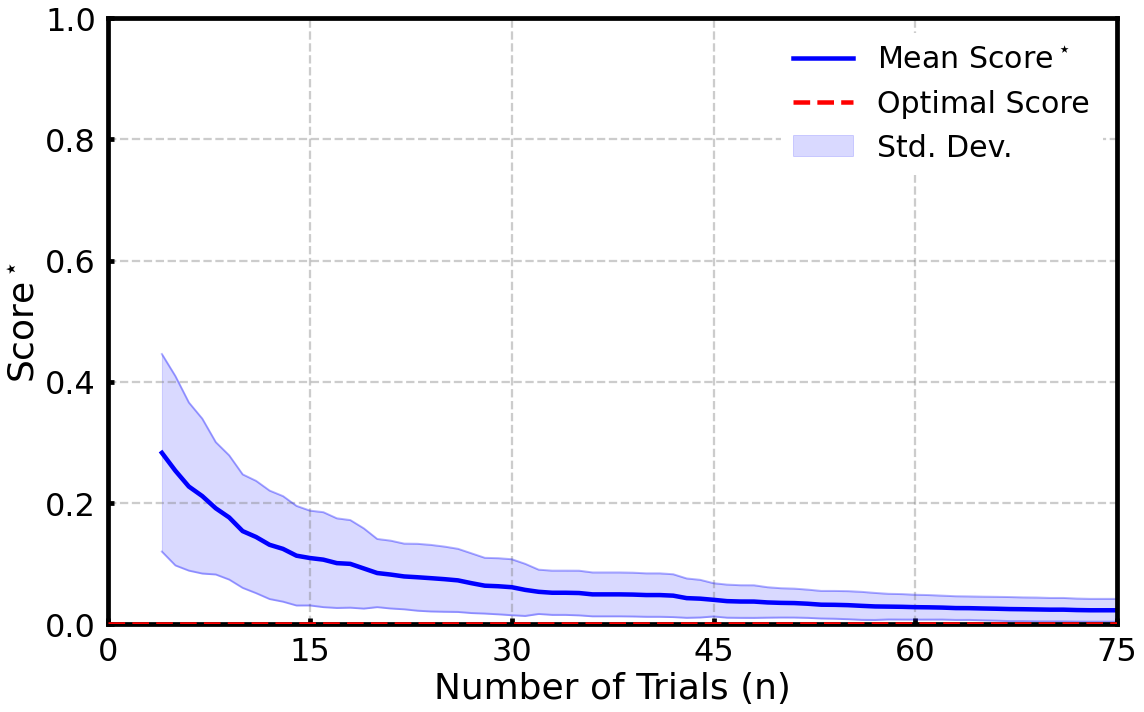

Final Score Across Runs:
Mean: 0.022
Standard Deviation: 0.0188


In [13]:
n_runs = 100 # Number of independent runs
trials = 75  # Number of trials per independent run

objectives_3 = {
    "Pout": {"target": 12, "limit": 5, "priority": 1},
    "PAE": {"target": 9, "limit": 5, "priority": 1},
    "Tj": {"target": 70, "limit": 125, "priority": 1}
}

# Run multiple HOLA optimization trials
benchmark_results_3 = utils.run_multiple_hola_trials(
    n_runs=n_runs,
    trials=trials,
    objectives=objectives_3,
    tune_function=tune,
    data_arrays=data_arrays,
    params_config=params_config
)

# Save results
utils.save_results_to_csv(benchmark_results_3, output_dir=r'./Pareto_designs/modulated_signal_objectives_3_results')

# Plot the benchmark results
utils.plot_benchmark_results(
    mean_scores=benchmark_results_3["mean_scores"],
    std_scores=benchmark_results_3["std_scores"],
    trials=trials,
    data_arrays=data_arrays,
    objectives=objectives_3
)

# Display aggregate statistics
print(f"Final Score Across Runs:")
print(f"Mean: {benchmark_results_3['final_mean']:.3f}")
print(f"Standard Deviation: {benchmark_results_3['final_std']:.4f}")


In [14]:
check_points = [1, 15, 30, 45, 60, 75] # Trial checkpoints
tolerance = 0.05 # Tolerance from optimal score

print("=== Evaluating Mean Score* ===")
utils.evaluate_mean_scores(
    benchmark_results=benchmark_results_3,
    check_points=check_points,
)

print("\n=== Evaluating Runs Reaching Optimal Score ===")
optimal_score_3, _ = utils.evaluate_runs(
    objectives=objectives_3,
    data_arrays=data_arrays,
    benchmark_results=benchmark_results_3,
    check_points=check_points,
    tolerance=None,
    compute_threshold_func=utils.compute_threshold,
    score_calculation_func=utils.calculate_score
)

print("\n=== Evaluating Runs Within Tolerance of Optimal Score ===")
optimal_score_3, threshold = utils.evaluate_runs(
    objectives=objectives_3,
    data_arrays=data_arrays,
    benchmark_results=benchmark_results_3,
    check_points=check_points,
    tolerance=tolerance,
    compute_threshold_func=utils.compute_threshold,
    score_calculation_func=utils.calculate_score
)

INFO: Optimal score: 0.0
INFO: Optimal score: 0.0


=== Evaluating Mean Score* ===
After 1 trials, the Mean Score: inf
After 15 trials, the Mean Score: 0.109
After 30 trials, the Mean Score: 0.060
After 45 trials, the Mean Score: 0.040
After 60 trials, the Mean Score: 0.027
After 75 trials, the Mean Score: 0.022

=== Evaluating Runs Reaching Optimal Score ===
After 1 trials, 0 out of 100 runs reached the optimal score.
After 15 trials, 5 out of 100 runs reached the optimal score.
After 30 trials, 7 out of 100 runs reached the optimal score.
After 45 trials, 13 out of 100 runs reached the optimal score.
After 60 trials, 22 out of 100 runs reached the optimal score.
After 75 trials, 28 out of 100 runs reached the optimal score.

=== Evaluating Runs Within Tolerance of Optimal Score ===
After 1 trials, 0 out of 100 runs are within 5.0% of the optimal score (optimal_score=0.000).
After 15 trials, 25 out of 100 runs are within 5.0% of the optimal score (optimal_score=0.000).
After 30 trials, 49 out of 100 runs are within 5.0% of the optimal 

INFO: Starting run 1/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet im

INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.29 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 4.0, 'wg': 100.0, 'gdg': 52, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 25.367639999999998, 'PAE': 15.842789999999999, 'Tj': 106.51206}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.42383633333333337
INFO: The score for trial 15 is: 0.1281516969696969
INFO: The score for trial 30 is: 0.04975066666666661
INFO: The score for trial 45 is: 0.04975066666666661
INFO:

INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Time taken for tuning: 0.27 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 4.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 25.367639999999998, 'PAE': 15.842789999999999, 'Tj': 106.51206}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.12827127272727312
INFO: The score for trial 30 is: 0.12827127272727312
INFO: The score for trial 45 is: 0.029140000000000055
INFO: The score for trial 60 is: 0.029140000000000055
INFO: The score for trial 75 is: 0.027492000000000096
INFO: Completed

INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.

INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Time taken for tuning: 0.28 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 4.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 24.5629, 'PAE': 15.388079999999999, 'Tj': 94.09775}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.533145
INFO: The score for trial 15 is: 0.11006933333333324
INFO: The score for trial 30 is: 0.029140000000000055
INFO: The score for trial 45 is: 0.029140000000000055
INFO: The score for trial 60 is: 0.029140000000000055
INFO: The score for trial 75 is: 0.029140000000000055
INFO: Completed run 18/100
INFO: Starting run 19/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.

INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.

INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Time taken for tuning: 0.28 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 8.0, 'wg': 75.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 26.477790000000002, 'PAE': 15.03604, 'Tj': 104.18158000000001}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.6054523333333333
INFO: The score for trial 15 is: 0.0
INFO: The score for trial 30 is: 0.0
INFO: The score for trial 45 is: 0.0
INFO: The score for trial 60 is: 0.0
INFO: The score for trial 75 is: 0.0
INFO: Completed run 27/100
INFO: Starting run 28/100
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not me

INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.29 seconds
INFO: Best Parameters

INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8, gdg=22.0, gsg=33.0
INFO: Time taken for tuning: 0.31 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 4.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 25.367639999999998, 'PAE': 15.842789999999999, 'Tj': 106.51206}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.7716003333333331
INFO: The score for trial 15 is: 0.13701612121212123
INFO: 

INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=52, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=52, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.30 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 6.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 26.52238, 'PAE': 15.23439, 'Tj': 104.995}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.7076749999999999
INFO: The score for trial 15 is: 0.06891254545454538
INFO: The score for trial 30 is: 

INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.32 seconds
INFO: Best Parameters:
INFO: {'vds': 20.0, 'nfing': 4.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 24.5629, 'PAE': 15.388079999999999, 'Tj': 94.09775}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.26244599999999996
INFO: The score for trial 30 is: 0.029140000000000055
INFO: The score for trial 45 is: 0.029140000000000055
INFO: The score for trial 60 is: 0.029140000000000055
INFO: The score for trial 75 is: 0.029140000000000055
INFO: Completed run 44/100
INFO: Starting run 45/100
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nf

INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=78
INFO: Device design does not meet imposed constraints: vds=20.0

INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.32 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 4.0, 'wg': 87.5, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {

INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.7419924848484847
INFO: The score for trial 15 is: 0.15601599999999982
INFO: The score for trial 30 is: 0.08724999999999997
INFO: The score for trial 45 is: 0.08724999999999997
INFO: The score for trial 60 is: 0.08724999999999997
INFO: The score for trial 75 is: 0.06971381818181845
INFO: Completed run 57/100
INFO: Starting run 58/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, 

INFO: The score for trial 45 is: 0.008312999999999904
INFO: The score for trial 60 is: 0.008312999999999904
INFO: The score for trial 75 is: 0.008312999999999904
INFO: Completed run 61/100
INFO: Starting run 62/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: v

INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Time taken for tuning: 0.29 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 4.0, 'wg': 100.0, 'gdg': 52.0, 'gsg': 48.0}
INFO: Best Objectives:
INFO: {'Pout': 25.140420000000002, 'PAE': 15.492029999999998, 'Tj': 109.79875}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: inf
INFO: The score for trial 15 is: 0.08724999999999997
INFO: The score for trial 30 is: 0.08724999999999997
INFO: The score for trial 45 is: 0.08724999999999997
INFO: The score for 

INFO: Best Objectives:
INFO: {'Pout': 24.06006, 'PAE': 15.356079999999999, 'Tj': 102.67551999999999}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.1891585454545457
INFO: The score for trial 15 is: 0.1891585454545457
INFO: The score for trial 30 is: 0.06266266666666664
INFO: The score for trial 45 is: 0.06266266666666664
INFO: The score for trial 60 is: 0.06266266666666664
INFO: The score for trial 75 is: 0.06266266666666664
INFO: Completed run 70/100
INFO: Starting run 71/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=

INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Time taken for tuning: 0.28 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 6.0, 'wg': 75.0, 'gdg': 22.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 24.86862, 'PAE': 15.276879999999998, 'Tj': 108.44776}
INFO: Optimal score: 0.0
INFO: The score f

INFO: Best Objectives:
INFO: {'Pout': 25.41662, 'PAE': 15.2997, 'Tj': 103.21439000000001}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 1.3628076666666664
INFO: The score for trial 15 is: 0.008312999999999904
INFO: The score for trial 30 is: 0.008312999999999904
INFO: The score for trial 45 is: 0.008312999999999904
INFO: The score for trial 60 is: 0.008312999999999904
INFO: The score for trial 75 is: 0.0
INFO: Completed run 79/100
INFO: Starting run 80/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: D

INFO: The score for trial 45 is: 0.04170533333333326
INFO: The score for trial 60 is: 0.04170533333333326
INFO: The score for trial 75 is: 0.04170533333333326
INFO: Completed run 83/100
INFO: Starting run 84/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=4.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=

INFO: The score for trial 60 is: 0.04170533333333326
INFO: The score for trial 75 is: 0.008312999999999904
INFO: Completed run 87/100
INFO: Starting run 88/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=50.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO

INFO: The score for trial 60 is: 0.04975066666666661
INFO: The score for trial 75 is: 0.027492000000000096
INFO: Completed run 91/100
INFO: Starting run 92/100
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=4.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=6.0, gdg=22.0, gsg=48.0
INFO:

INFO: Device design does not meet imposed constraints: vds=24.0, wg=100.0, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=50.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=100.0, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=75.0, nfing=4.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=48.0
INFO: Device design does not meet imposed constraints: vds=24.0, wg=87.5, nfing=8.0, gdg=22.0, gsg=78
INFO: Time taken for tuning: 0.27 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 6.0, 'wg': 75.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 24.92836, 'PAE': 14.96463, 'Tj': 103.56729}
INFO: Optimal score: 0.0
INFO: The score for trial 1 

INFO: Device design does not meet imposed constraints: vds=20.0, wg=75.0, nfing=6.0, gdg=22.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=37.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=62.5, nfing=8.0, gdg=22.0, gsg=33.0
INFO: Device design does not meet imposed constraints: vds=16.0, wg=87.5, nfing=8.0, gdg=52.0, gsg=78.0
INFO: Device design does not meet imposed constraints: vds=20.0, wg=100.0, nfing=6.0, gdg=52.0, gsg=33.0
INFO: Time taken for tuning: 0.27 seconds
INFO: Best Parameters:
INFO: {'vds': 24.0, 'nfing': 8.0, 'wg': 75.0, 'gdg': 52.0, 'gsg': 78.0}
INFO: Best Objectives:
INFO: {'Pout': 26.477790000000002, 'PAE': 15.03604, 'Tj': 104.18158000000001}
INFO: Optimal score: 0.0
INFO: The score for trial 1 is: 0.3378593333333335
INFO: The score for trial 15 is: 0.15465057575757604
INFO: The score for trial 30 is: 0.08724999999999997
INFO: The score for trial 45 is: 0.08724999999999997
INFO: 

Saved all_score_tallies.csv to Pareto_designs/modulated_signal_objectives_4_results/all_score_tallies.csv
Saved mean_std_scores.csv to Pareto_designs/modulated_signal_objectives_4_results/mean_std_scores.csv
Saved final_scores.csv to Pareto_designs/modulated_signal_objectives_4_results/final_scores.csv
Saved final_statistics.csv to Pareto_designs/modulated_signal_objectives_4_results/final_statistics.csv


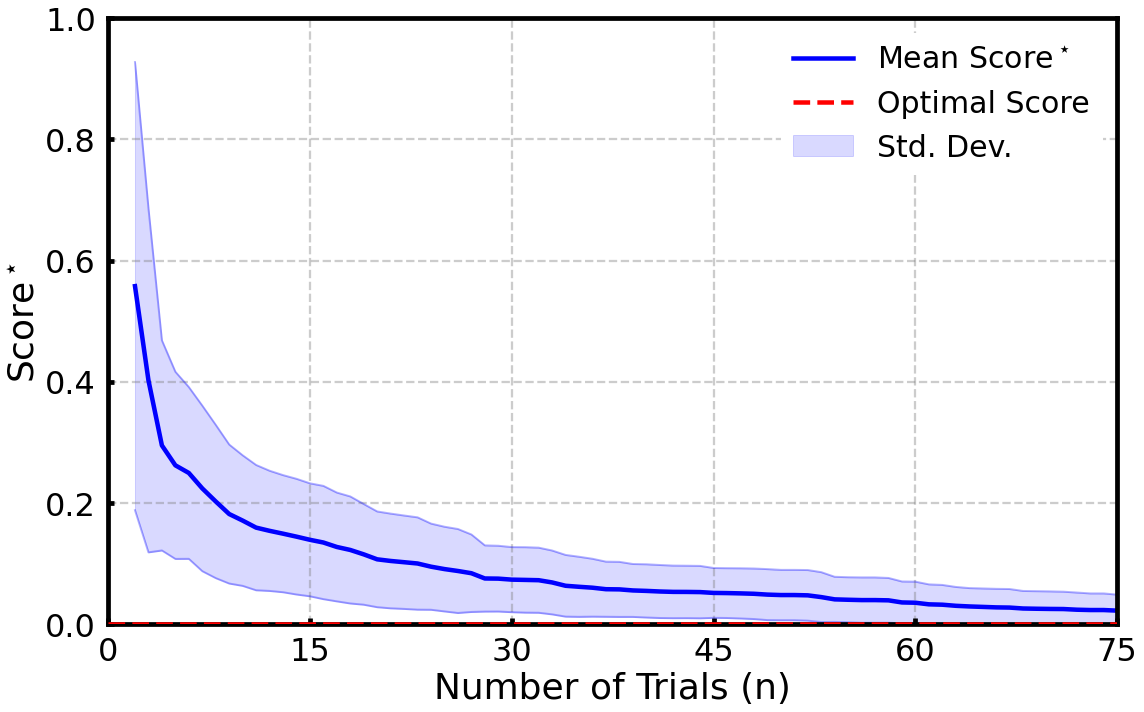

Final Score Across Runs:
Mean: 0.022
Standard Deviation: 0.0264


In [15]:
n_runs = 100 # Number of independent runs
trials = 75  # Number of trials per independent run

objectives_4 = {
    "Pout": {"target": 25, "limit": 10, "priority": 1},
    "PAE": {"target": 15, "limit": 5, "priority": 1},
    "Tj": {"target": 105, "limit": 160, "priority": 1}
}

# Run multiple HOLA optimization trials
benchmark_results_4 = utils.run_multiple_hola_trials(
    n_runs=n_runs,
    trials=trials,
    objectives=objectives_4,
    tune_function=tune,
    data_arrays=data_arrays,
    params_config=params_config
)

# Save results
utils.save_results_to_csv(benchmark_results_4, output_dir=r'./Pareto_designs/modulated_signal_objectives_4_results')

# Plot the benchmark results
utils.plot_benchmark_results(
    mean_scores=benchmark_results_4["mean_scores"],
    std_scores=benchmark_results_4["std_scores"],
    trials=trials,
    data_arrays=data_arrays,
    objectives=objectives_4
)

# Display aggregate statistics
print(f"Final Score Across Runs:")
print(f"Mean: {benchmark_results_4['final_mean']:.3f}")
print(f"Standard Deviation: {benchmark_results_4['final_std']:.4f}")

In [16]:
check_points = [1, 15, 30, 45, 60, 75] # Trial checkpoints
tolerance = 0.05 # Tolerance from optimal score

print("=== Evaluating Mean Score* ===")
utils.evaluate_mean_scores(
    benchmark_results=benchmark_results_4,
    check_points=check_points,
)

print("\n=== Evaluating Runs Reaching Optimal Score ===")
optimal_score_4, _ = utils.evaluate_runs(
    objectives=objectives_4,
    data_arrays=data_arrays,
    benchmark_results=benchmark_results_4,
    check_points=check_points,
    tolerance=None,
    compute_threshold_func=utils.compute_threshold,
    score_calculation_func=utils.calculate_score
)

print("\n=== Evaluating Runs Within Tolerance of Optimal Score ===")
optimal_score_4, threshold = utils.evaluate_runs(
    objectives=objectives_4,
    data_arrays=data_arrays,
    benchmark_results=benchmark_results_4,
    check_points=check_points,
    tolerance=tolerance,
    compute_threshold_func=utils.compute_threshold,
    score_calculation_func=utils.calculate_score
)

INFO: Optimal score: 0.0
INFO: Optimal score: 0.0


=== Evaluating Mean Score* ===
After 1 trials, the Mean Score: inf
After 15 trials, the Mean Score: 0.139
After 30 trials, the Mean Score: 0.073
After 45 trials, the Mean Score: 0.051
After 60 trials, the Mean Score: 0.035
After 75 trials, the Mean Score: 0.022

=== Evaluating Runs Reaching Optimal Score ===
After 1 trials, 0 out of 100 runs reached the optimal score.
After 15 trials, 9 out of 100 runs reached the optimal score.
After 30 trials, 14 out of 100 runs reached the optimal score.
After 45 trials, 17 out of 100 runs reached the optimal score.
After 60 trials, 27 out of 100 runs reached the optimal score.
After 75 trials, 39 out of 100 runs reached the optimal score.

=== Evaluating Runs Within Tolerance of Optimal Score ===
After 1 trials, 0 out of 100 runs are within 5.0% of the optimal score (optimal_score=0.000).
After 15 trials, 17 out of 100 runs are within 5.0% of the optimal score (optimal_score=0.000).
After 30 trials, 39 out of 100 runs are within 5.0% of the optimal

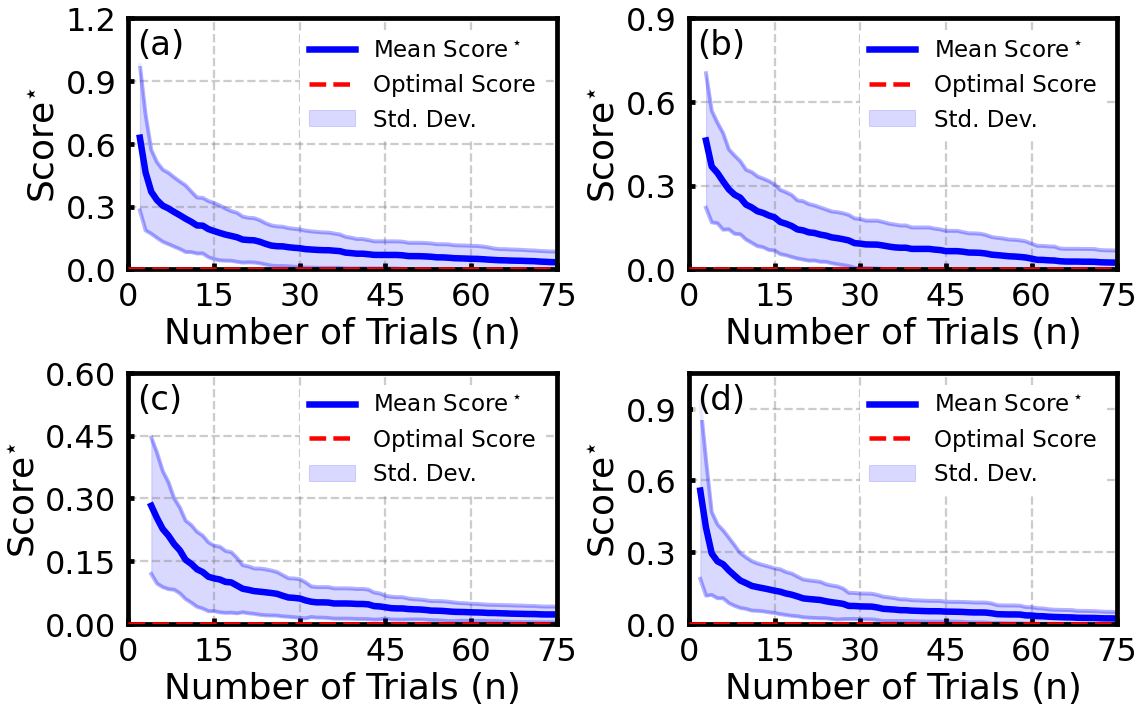

In [17]:
# Data for plotting (mean and standard deviation)
benchmark_results_1 = {
    "mean_scores": benchmark_results_1["mean_scores"],
    "std_scores": benchmark_results_1["std_scores"]
}
benchmark_results_2 = {
    "mean_scores": benchmark_results_2["mean_scores"],
    "std_scores": benchmark_results_2["std_scores"]
}
benchmark_results_3 = {
    "mean_scores": benchmark_results_3["mean_scores"],
    "std_scores": benchmark_results_3["std_scores"]
}
benchmark_results_4 = {
    "mean_scores": benchmark_results_4["mean_scores"],
    "std_scores": benchmark_results_4["std_scores"]
}

benchmark_results = [
    benchmark_results_1,
    benchmark_results_2,
    benchmark_results_3,
    benchmark_results_4
]

# Optimal scores for each subplot
optimal_scores = [optimal_score_1, optimal_score_2, optimal_score_3, optimal_score_4]

# Define labels
x_labels = [
    r'Number of Trials (n)',
    r'Number of Trials (n)',
    r'Number of Trials (n)',
    r'Number of Trials (n)'
]

y_labels = [
    r'Score$^{\star}$',
    r'Score$^{\star}$',
    r'Score$^{\star}$',
    r'Score$^{\star}$'
]

# Define ticks
x_ticks = [
    np.arange(0, trials + 1, 15),
    np.arange(0, trials + 1, 15),
    np.arange(0, trials + 1, 15),
    np.arange(0, trials + 1, 15)
]

utils.subplot_benchmark_results(
    trials=trials,
    benchmark_results=benchmark_results,
    optimal_scores=optimal_scores,
    x_labels=x_labels,
    y_labels=y_labels,
    x_ticks=x_ticks,
    figsize=(16, 10),
    save_path="Fig_4_v6_test.pdf"  # Set to None if you don't want to save
)